In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random

In [20]:
%cd "C:\Project\Dataset"

C:\Project\Dataset


In [21]:
brain_dataframe = pd.read_csv('data_mask.csv')

In [22]:
brain_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [23]:
brain_dataframe.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [24]:
brain_dataframe.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [25]:
brain_dataframe.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [26]:
brain_dataframe[:5]

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [27]:
brain_dataframe['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [28]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_dataframe['mask'].value_counts().index, y = brain_dataframe['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(51,51,255)', marker_line_color = 'rgb(0,0,0)',marker_line_width = 2, opacity = 0.6)
fig.show()

In [29]:
round((brain_dataframe['mask'].value_counts()* 100 / len(brain_dataframe['mask'])),2)

0    65.05
1    34.95
Name: mask, dtype: float64

In [30]:
brain_dataframe.mask_path[:5]

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
Name: mask_path, dtype: object

In [31]:
brain_dataframe.image_path[:5]

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
Name: image_path, dtype: object

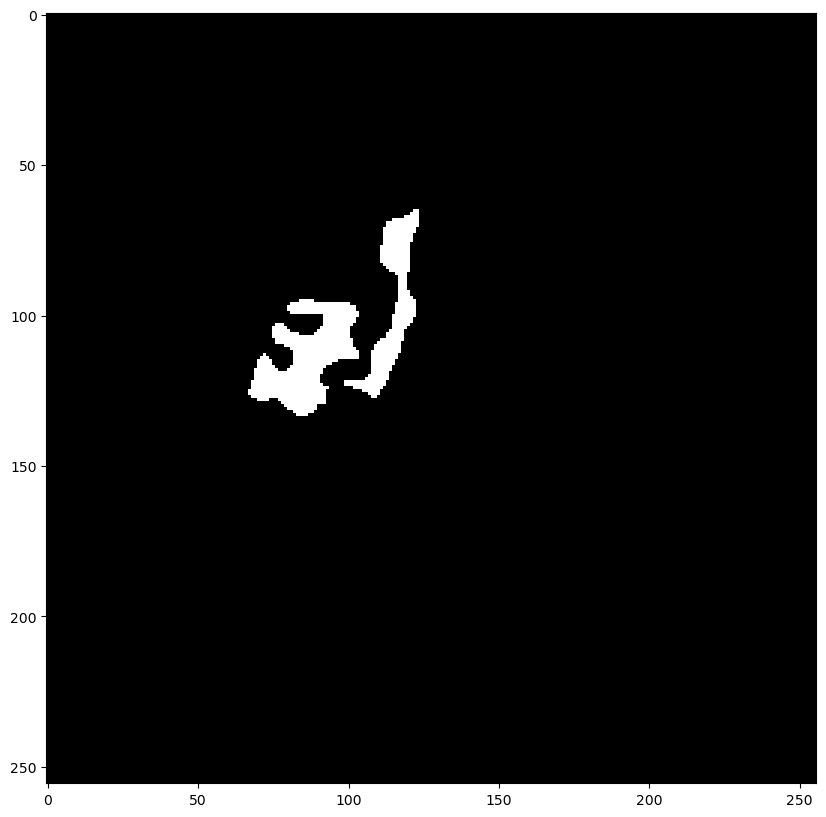

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(brain_dataframe.mask_path[2490]))
plt.show()

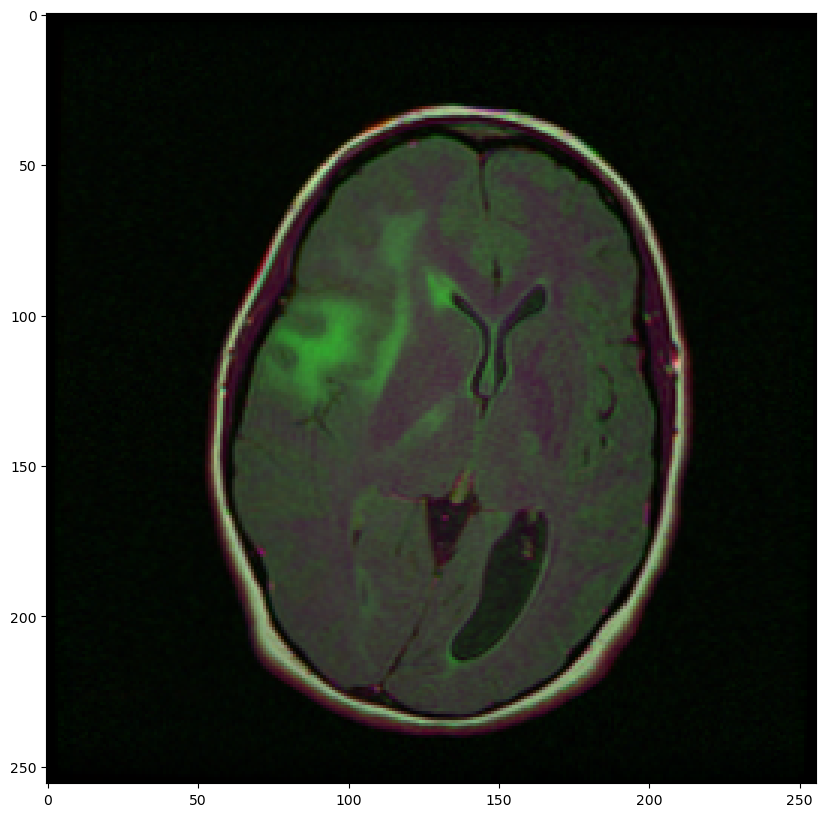

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(brain_dataframe.image_path[2490]))
plt.show()

In [34]:
cv2.imread(brain_dataframe.mask_path[2490]).max()

255

In [35]:
cv2.imread(brain_dataframe.mask_path[2490]).min()

0

# Basic Visualization

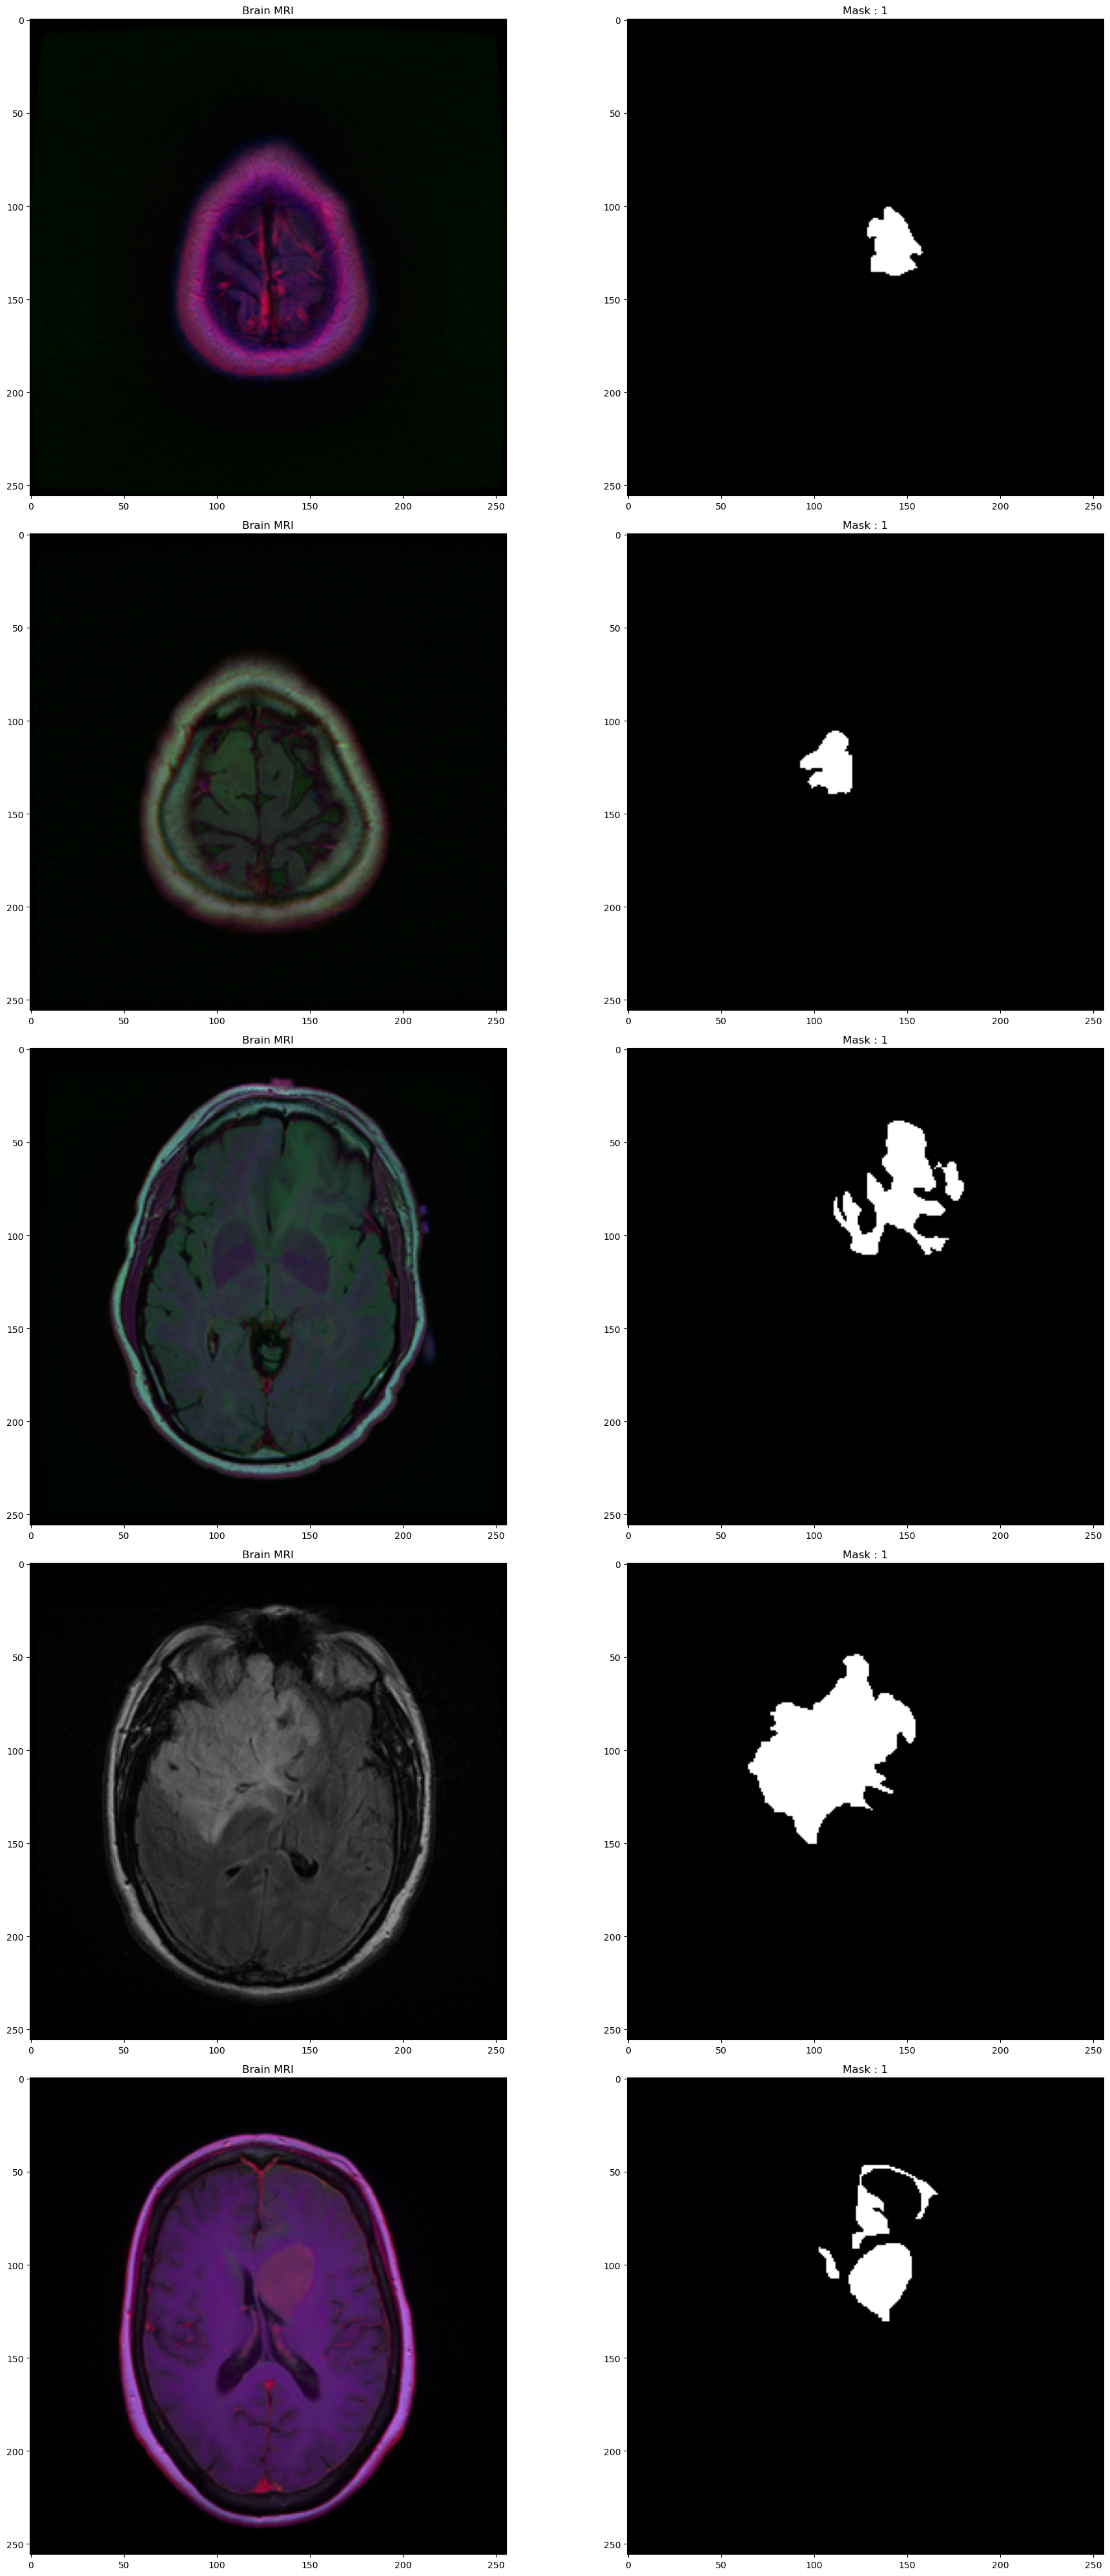

In [36]:
import random
fig, axis = plt.subplots(5,2, figsize=(20,40))
count = 0
for x in range(5):
  i = random.randint(0, len(brain_dataframe)) # select a random index 
  axis[count][0].title.set_text("Brain MRI") # set title
  axis[count][0].imshow(cv2.imread(brain_dataframe.image_path[i])) # show MRI 
  axis[count][1].title.set_text("Mask : " + str(brain_dataframe['mask'][i])) # plot title on the mask (0 or 1)
  axis[count][1].imshow(cv2.imread(brain_dataframe.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

# Advanced Visualization

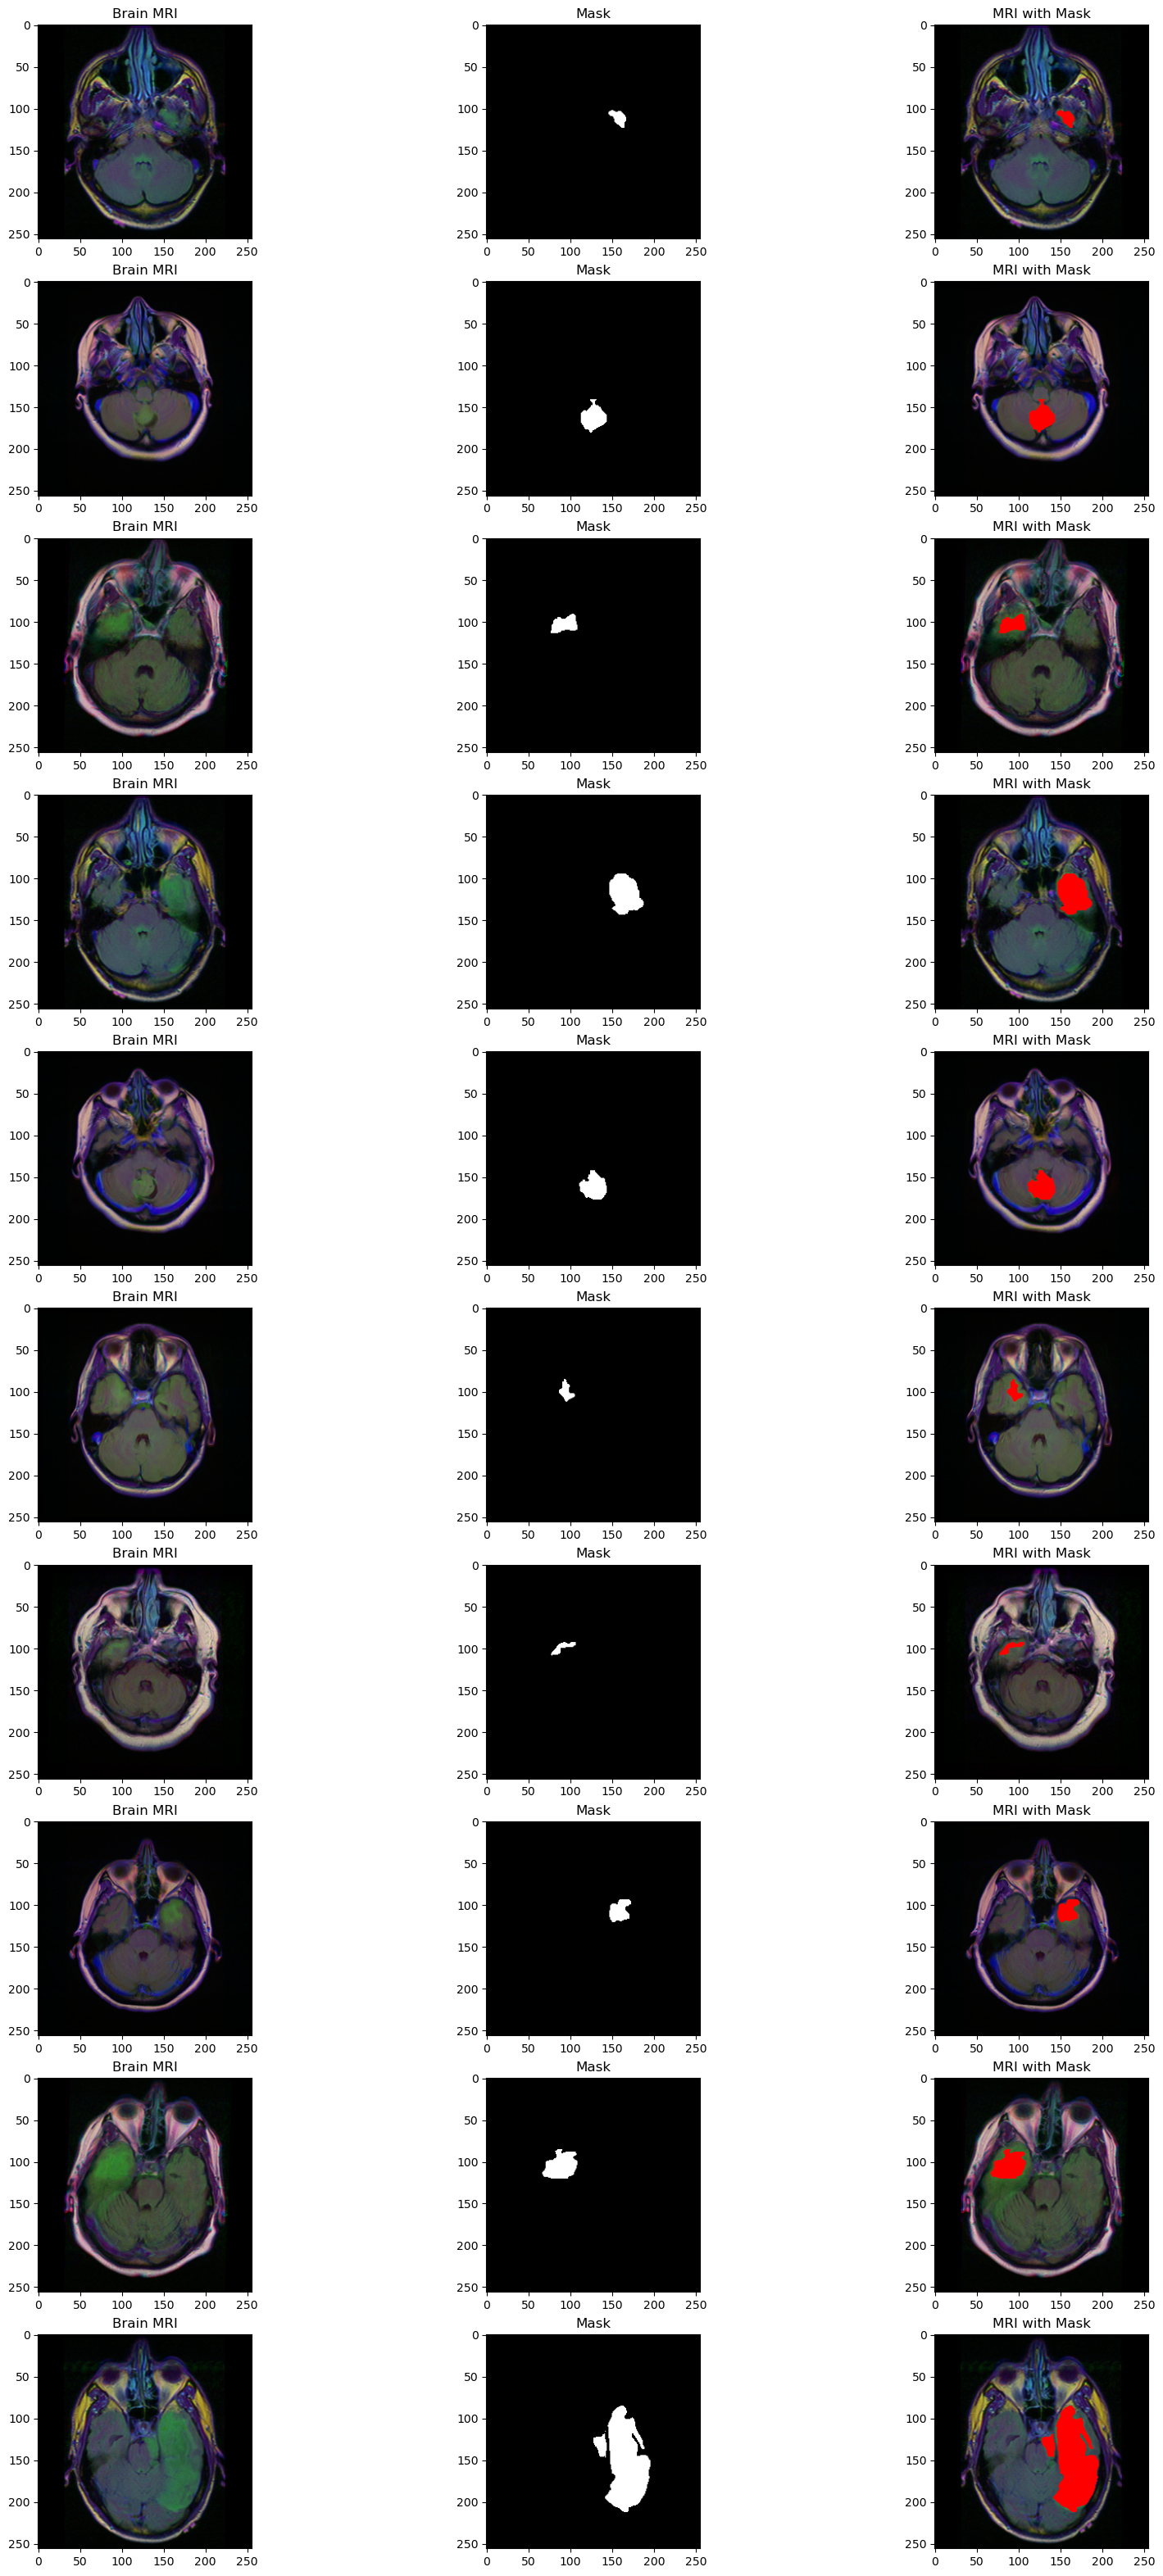

In [37]:
count = 0
fig, axis = plt.subplots(10, 3, figsize = (20, 40))
for i in range(len(brain_dataframe)):
  if brain_dataframe['mask'][i] ==1 and count <10:
    img = io.imread(brain_dataframe.image_path[i])
    axis[count][0].title.set_text('Brain MRI')
    axis[count][0].imshow(img)

    mask = io.imread(brain_dataframe.mask_path[i])
    axis[count][1].title.set_text('Mask')
    axis[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axis[count][2].title.set_text('MRI with Mask')
    axis[count][2].imshow(img)
    count+=1

# Training a Model

In [38]:
brain_dataframe_train = brain_dataframe.drop(columns = ['patient_id'])
brain_dataframe_train.shape

(3929, 3)

In [39]:
brain_dataframe_train['mask'] = brain_dataframe_train['mask'].apply(lambda x: str(x))

In [40]:
brain_dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [41]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_dataframe_train, test_size = 0.2,random_state=42)

In [43]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.1)

In [44]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2829 validated image filenames belonging to 2 classes.
Found 314 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [45]:
basemodel =ResNet101(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

171446536/171446536 [==============================] - 22s 0us/step


In [46]:
basemodel.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [47]:
for layer in basemodel.layers:
  layers.trainable = False

In [48]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [50]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=25
                             )
checkpointer = ModelCheckpoint(filepath="C:\Project\Dataset\Model\Classifier_ResNet101_Model.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [51]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [52]:
history = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 100, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks = [checkpointer, earlystopping, reduce_lr])

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.6850
Epoch 1: val_loss improved from inf to 0.65507, saving model to C:\Project\Dataset\Model\Classifier_ResNet101_Model.hdf5
176/176 [==============================] - 1488s 8s/step - loss: 0.7493 - accuracy: 0.6850 - val_loss: 0.6551 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7917
Epoch 2: val_loss improved from 0.65507 to 0.65080, saving model to C:\Project\Dataset\Model\Classifier_ResNet101_Model.hdf5
176/176 [==============================] - 1463s 8s/step - loss: 0.4854 - accuracy: 0.7917 - val_loss: 0.6508 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8102
Epoch 3: val_loss did not improve from 0.65080
176/176 [==============================] - 1489s 8s/step - loss: 0.4449 - accuracy: 0.8102 - val_loss: 0.7217 - val_accuracy

In [53]:
history

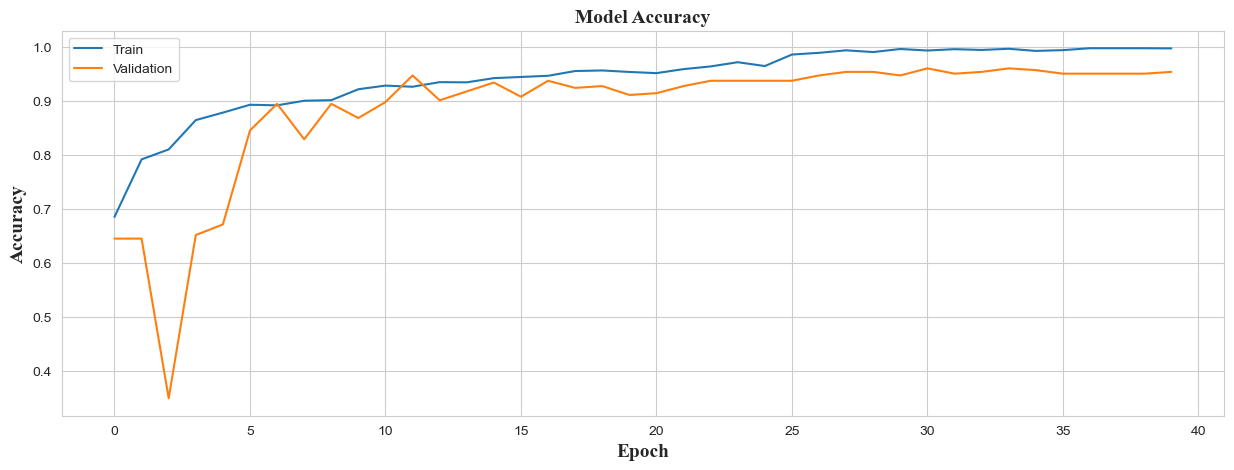

In [54]:
csfont = {'fontname':'Times New Roman','size':14,'weight':'bold'}
plt.figure(figsize = [15, 5])
sns.set_style('whitegrid')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy',**csfont)
plt.ylabel('Accuracy',**csfont)
plt.xlabel('Epoch',**csfont)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

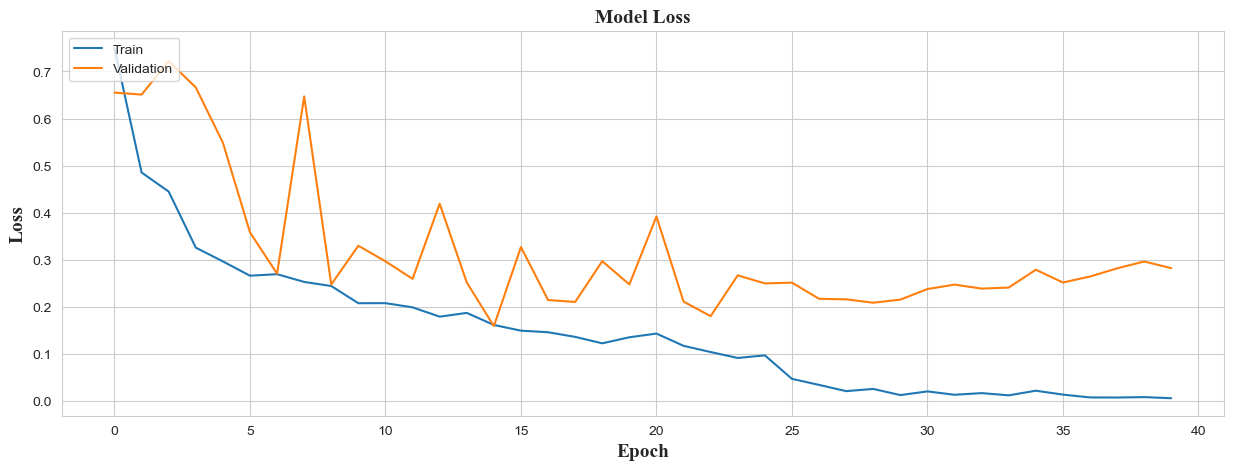

In [55]:
csfont = {'fontname':'Times New Roman','size':14,'weight':'bold'}
plt.figure(figsize = [15, 5])
sns.set_style('whitegrid')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',**csfont)
plt.ylabel('Loss',**csfont)
plt.xlabel('Epoch',**csfont)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Save Model

In [61]:
model_json = model.to_json()
with open("C:\Project\Dataset\Model\classifierResNet101model.json", "w") as json_file:
    json_file.write(model_json)

# Assess Training Model Performance

In [62]:
with open('C:\Project\Dataset\Model\classifierResNet101model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('C:\Project\Dataset\Model\Classifier_ResNet101_Model.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [63]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

49/49 [==============================] - 77s 2s/step


In [64]:
test_predict.shape

(784, 2)

In [65]:
test_predict[:5]

array([[0.05635118, 0.9436489 ],
       [0.3775091 , 0.62249094],
       [0.913772  , 0.08622798],
       [0.1352631 , 0.8647369 ],
       [0.99003893, 0.00996106]], dtype=float32)

In [66]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [67]:
predict

array(['1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1',
       '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1',
       '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0',
       '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1',
       '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1',
       '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0',
       '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0

In [68]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

784

In [69]:
from sklearn.metrics import accuracy_score

accuracy = round(accuracy_score(original, predict),2)
accuracy

0.92

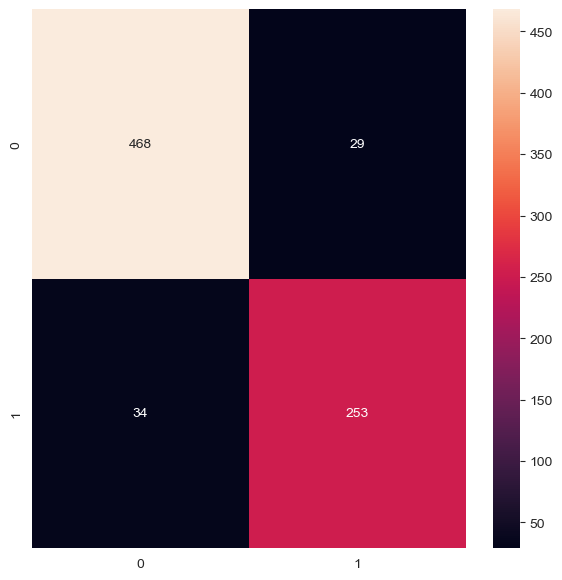

In [70]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True,fmt='d')
plt.show()

In [71]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       497
           1       0.90      0.88      0.89       287

   micro avg       0.92      0.92      0.92       784
   macro avg       0.91      0.91      0.91       784
weighted avg       0.92      0.92      0.92       784



C:\Users\anshi\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\anshi\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\anshi\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\anshi\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# Build A Segmentation Model To Localize Tumor

In [72]:
brain_dataframe_mask = brain_dataframe[brain_dataframe['mask'] == 1]
brain_dataframe_mask.shape

(1373, 4)

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_dataframe_mask, test_size=0.2,random_state=42)
X_test, X_val = train_test_split(X_val, test_size=0.5,random_state=42)

In [74]:
X_train.shape,X_test.shape, X_val.shape

((1098, 4), (137, 4), (138, 4))

In [75]:

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [76]:
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [77]:
def resblock(X, f):
  

  # make a copy of input
    X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

    X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    
    return X

In [78]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [79]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [80]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

# Train a Segmentation Resunet Model to Localize Tumor

In [81]:
from utilities import tversky_loss, tversky

In [82]:
def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #print(type(y_pred))
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [83]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=25
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="C:\Project\Dataset\Model\ResNet101_ResUNet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [84]:
history = model_seg.fit(training_generator, epochs = 100, validation_data = validation_generator,
                        callbacks = [checkpointer, earlystopping,reduce_lr])

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.9203 - tversky: 0.1048
Epoch 1: val_loss improved from inf to 0.93204, saving model to C:\Project\Dataset\Model\ResNet101_ResUNet-weights.hdf5
68/68 [==============================] - 186s 3s/step - loss: 0.9203 - tversky: 0.1048 - val_loss: 0.9320 - val_tversky: 0.0895 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.9100 - tversky: 0.1181
Epoch 2: val_loss improved from 0.93204 to 0.91842, saving model to C:\Project\Dataset\Model\ResNet101_ResUNet-weights.hdf5
68/68 [==============================] - 195s 3s/step - loss: 0.9100 - tversky: 0.1181 - val_loss: 0.9184 - val_tversky: 0.1072 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.8986 - tversky: 0.1327
Epoch 3: val_loss improved from 0.91842 to 0.89802, saving model to C:\Project\Dataset\Model\ResNet101_ResUNet-weights.hdf5
68/68 [==============================] - 200s 3s/step - loss: 0.8986

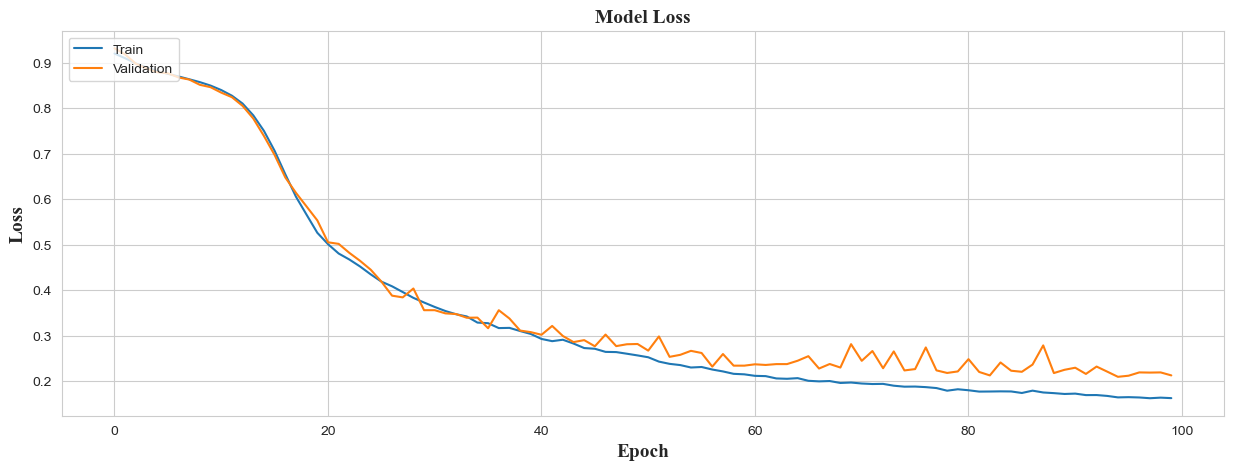

In [85]:
csfont = {'fontname':'Times New Roman','size':14,'weight':'bold'}
plt.figure(figsize = [15, 5])
sns.set_style('whitegrid')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',**csfont)
plt.ylabel('Loss',**csfont)
plt.xlabel('Epoch',**csfont)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

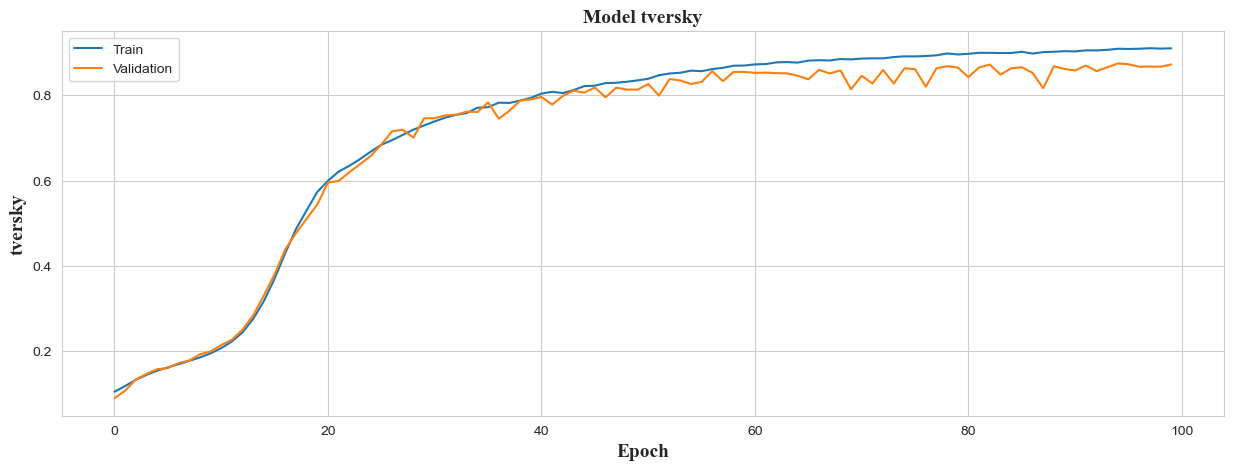

In [86]:
csfont = {'fontname':'Times New Roman','size':14,'weight':'bold'}
plt.figure(figsize = [15, 5])
sns.set_style('whitegrid')
plt.plot(history.history['tversky'])
plt.plot(history.history['val_tversky'])
plt.title('Model tversky',**csfont)
plt.ylabel('tversky',**csfont)
plt.xlabel('Epoch',**csfont)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [87]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("C:\Project\Dataset\Model\ResNet101-model.json","w") as json_file:
    json_file.write(model_json)

In [88]:
from utilities import focal_tversky, tversky_loss, tversky

with open('C:\Project\Dataset\Model\ResNet101-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

In [89]:
model_seg1 = tf.keras.models.model_from_json(json_savedModel)
model_seg1.load_weights('C:\Project\Dataset\Model\ResNet101_ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg1.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [90]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg1)

1/1 [==============================] - 0s 214ms/step


In [91]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred.head()

image_path  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...   

                                      predicted_mask  has_mask  
0  [[[[0.00010544], [0.00025779], [9.016691e-05],...         1  
1  [[[[0.00019949], [4.1236573e-05], [6.1720707e-...         1  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

In [92]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...   

                                           mask_path mask  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...    1   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...    0   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...    0   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...    0   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...    0   

                                      predicted_mask  has_mask  
0  [[[[0.00010544], [0.00025779], [9.016691e-05],...         1  
1  [[[[0.00019949], [4.1236573e-05], [6.1720707e-...         1  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

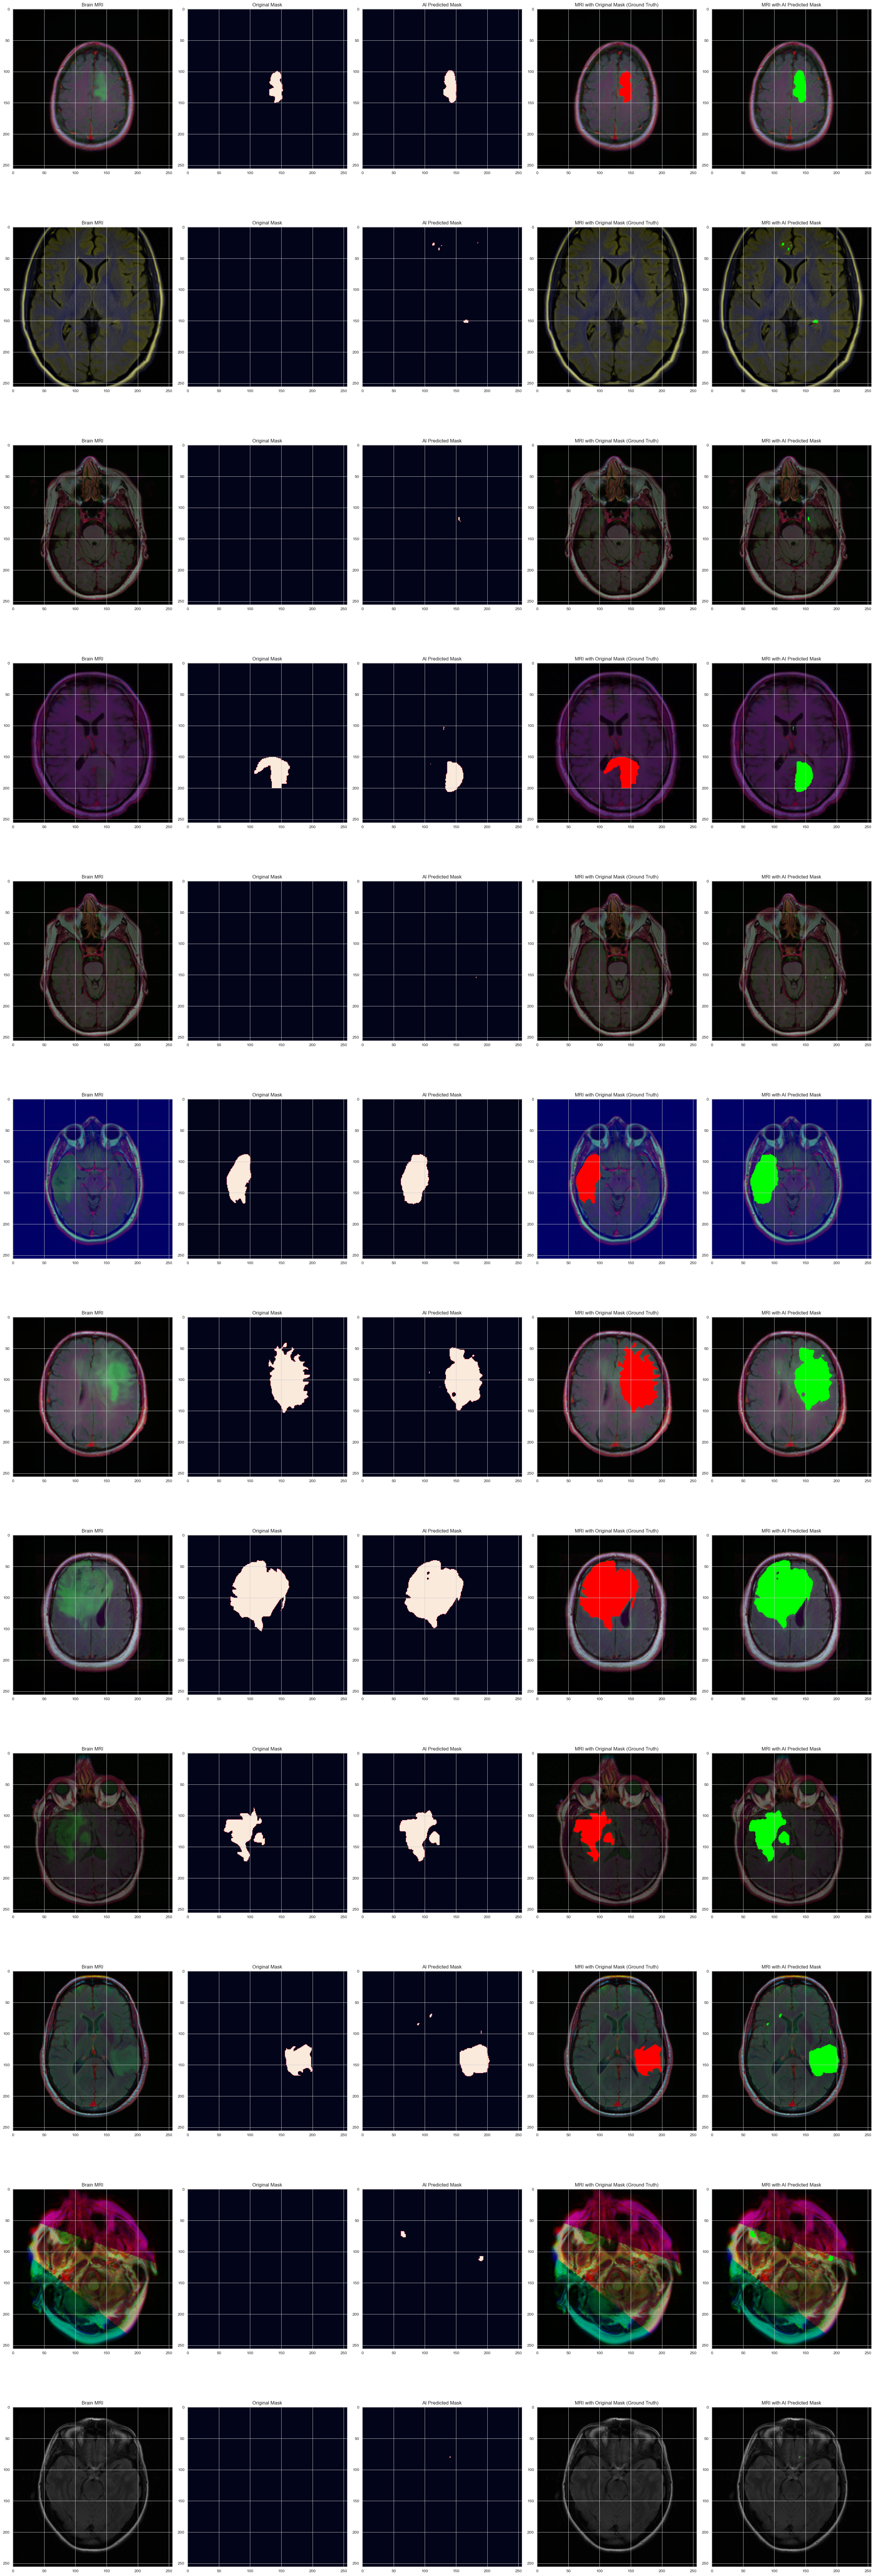

In [93]:
count = 0 
fig, axs = plt.subplots(12, 5, figsize=(30,90))
for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 12:
        # read the images and convert them to RGB format
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        # Obtain the mask for the image 
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].title.set_text("Original Mask")
        axs[count][1].imshow(mask)

        # Obtain the predicted mask for the image 
        predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
        axs[count][2].title.set_text("AI Predicted Mask")
        axs[count][2].imshow(predicted_mask)

        # Apply the mask to the image 'mask==255'
        img[mask == 255] = (255, 0, 0)
        axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
        axs[count][3].imshow(img)

        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[predicted_mask == 1] = (0, 255, 0)
        axs[count][4].title.set_text("MRI with AI Predicted Mask")
        axs[count][4].imshow(img_)
        count += 1

fig.tight_layout()